In [1]:
%load_ext autoreload
%autoreload 2
    
import helper_methods_for_aggregate_data_analysis as helper
import covid_constants_and_util as cu
from dataset import *
from model_experiments import *
from results import *

import metis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import time 
import pandas as pd
import geopandas as gpd
import torch as t
from collections import Counter
import copy
from scipy.stats import pearsonr, linregress
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
import datetime 

Setting numpy cores to 1
Running code on rambo.stanford.edu; at Stanford=True


/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Importing plotly failed. Interactive plots will not work.


# Figure 1. Data

In [2]:
# load tiers data 
directory = os.path.join(cu.BASE_DIR, 'external_datasets_for_aggregate_analysis/blueprints_cdph')
fns = sorted(os.listdir(directory))
results_df = []
for fn in fns:
    mapping = {'date': ['date of tier assessment', 'date of tier assignment'],
               'tier': ['final tier', 'updated tier assignment', 'updated overall tier status',
                        'tier assignment 9/15'] }
    cols = {k:None for k in mapping}
    header = 0
    while cols['date'] is None and cols['tier'] is None and header <= 10:
        df = pd.read_excel(os.path.join(directory, fn), header=header)
        df = df.iloc[:58]  # already in alphabetical order of counties
        for orig_col in df.columns:
            if type(orig_col) == str:
                for k, possibilities in mapping.items():
                    for v in possibilities:
                        if v in orig_col.lower():
                            cols[k] = orig_col
        header += 1
#     print(header-1, fn, cols['date'], '+', cols['tier'])
    if cols['tier'] is None:
        print('Couldn\'t find tier column, skipping', fn)
    else:
        if cols['date'] is None:
            print(fn, 'getting date from filename')
            ds = (fn.split('.')[0]).split('_')[-1]
            dt = datetime.datetime.strptime(ds, '%m%d%y')
            ds = dt.strftime('%Y-%m-%d')
        else:
            dates = df[cols['date']].values
            assert all(dates[0] == dates)  # should all be the same date
            ds = pd.to_datetime(dates[0]).strftime('%Y-%m-%d')
        results = {'date':ds}
        for i, tier in enumerate(df[cols['tier']].values):
            results[i] = tier
        if len(results) != 59:
            print(fn, len(results))
        results_df.append(results)
columns = list(results_df[-1].keys())
results_df = pd.DataFrame(results_df, columns=columns).sort_values(by='date')
tier_datetimes = [datetime.datetime.strptime(s, '%Y-%m-%d') for s in results_df.date.values]

/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Couldn't find tier column, skipping Blueprint_Data_Chart_083120.xlsx
Blueprint_Data_Chart_111620.xlsx getting date from filename
Blueprint_Data_Chart_112420.xlsx getting date from filename
Blueprint_Data_Chart_112820.xlsx getting date from filename
Blueprint_Data_Chart_120120.xlsx getting date from filename


In [3]:
# load mobility data
with open(os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/visits.pkl'), 'rb') as f:
    visits = pickle.load(f)
print(len(visits))
with open(os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/index.pkl'), 'rb') as f:
    indices = pickle.load(f)
assert len(visits) == len(indices['weeks'])
print(indices['weeks'][-1])  # last week

121
2021-04-19


In [4]:
# find intersection of time periods
tier_datetimes = np.array([datetime.datetime.strptime(s, '%Y-%m-%d') for s in results_df.date.values])
mobility_datetimes = np.array([datetime.datetime.strptime(s, '%Y-%m-%d') for s in indices['weeks']])
min_intersect = max(tier_datetimes[0], mobility_datetimes[0])
max_intersect = min(tier_datetimes[-1], mobility_datetimes[-1])
print(min_intersect, max_intersect)

2020-09-08 00:00:00 2021-04-19 00:00:00


## Figure 1a. Tiers over time 

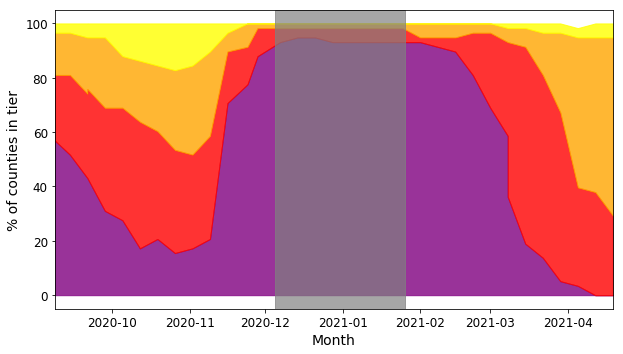

In [6]:
tier2color = {1:'purple',
              2:'red',
              3:'orange',
              4:'yellow'}
within_range = (tier_datetimes >= min_intersect) & (tier_datetimes <= max_intersect)
kept_datetimes = tier_datetimes[within_range]
tier_mat = results_df.values[within_range, 1:]  # skip date column

fig, ax = plt.subplots(figsize=(10, 5.5))
base = np.zeros(len(kept_datetimes))
for tier in [1, 2, 3, 4]:
    prop_in_tier = 100. * np.sum(tier_mat == tier, axis=1) / 58
    ax.fill_between(kept_datetimes, base, base+prop_in_tier, linestyle='-', color=tier2color[tier], alpha=0.8)
    base = base + prop_in_tier
ax.axvspan(datetime.datetime(2020, 12, 5), datetime.datetime(2021, 1, 26), alpha=0.7, color='grey')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_intersect, max_intersect)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('% of counties in tier', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figs/fig1a.pdf', bbox_inches='tight')

## Figure 1b. County map of tiers

In [7]:
# 9-week period that we study, including 2 for 3/08/21
week_index = list(kept_datetimes).index(datetime.datetime(2021, 2, 1))
for i in range(week_index, week_index+10):
    tiers = tier_mat[i]
    print(i, kept_datetimes[i], Counter(tiers))

23 2021-02-01 00:00:00 Counter({1.0: 54, 3.0: 3, 2.0: 1})
24 2021-02-08 00:00:00 Counter({1.0: 53, 3.0: 3, 2.0: 2})
25 2021-02-15 00:00:00 Counter({1.0: 52, 3.0: 3, 2.0: 3})
26 2021-02-22 00:00:00 Counter({1.0: 47, 2.0: 9, 3.0: 2})
27 2021-03-01 00:00:00 Counter({1.0: 40, 2.0: 16, 3.0: 2})
28 2021-03-08 00:00:00 Counter({1.0: 34, 2.0: 20, 3.0: 3, 4.0: 1})
29 2021-03-08 00:00:00 Counter({2.0: 33, 1.0: 21, 3.0: 3, 4.0: 1})
30 2021-03-15 00:00:00 Counter({2.0: 42, 1.0: 11, 3.0: 4, 4.0: 1})
31 2021-03-22 00:00:00 Counter({2.0: 39, 3.0: 9, 1.0: 8, 4.0: 2})
32 2021-03-29 00:00:00 Counter({2.0: 36, 3.0: 17, 1.0: 3, 4.0: 2})


In [8]:
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
ca_geom = geoData[geoData['STATE'] == '06'].sort_values(by='id')
ca_geom.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
2248,06001,0500000US06001,06,001,Alameda,County,739.017,"POLYGON ((-121.85576 37.48454, -122.04527 37.4..."
684,06003,0500000US06003,06,003,Alpine,County,738.332,"POLYGON ((-120.07239 38.70277, -119.88030 38.8..."
23,06005,0500000US06005,06,005,Amador,County,594.583,"POLYGON ((-120.99550 38.22541, -121.02708 38.3..."
685,06007,0500000US06007,06,007,Butte,County,1636.464,"POLYGON ((-121.07670 39.59726, -121.14991 39.5..."
740,06009,0500000US06009,06,009,Calaveras,County,1020.012,"POLYGON ((-120.65267 37.83142, -120.92645 38.0..."


Counter({'red': 42, 'purple': 11, 'orange': 4, 'yellow': 1})


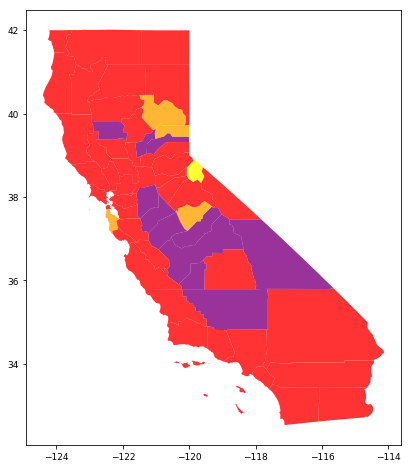

In [9]:
week_index = list(kept_datetimes).index(datetime.datetime(2021, 3, 15))
colors = [tier2color[t] for t in tier_mat[week_index]]
print(Counter(colors))
fig, ax = plt.subplots(figsize=(8, 8))
ca_geom.plot(color=colors, ax=ax, alpha=0.8)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('./figs/fig1b.pdf', bbox_inches='tight')

## Figure 1c. Mobility over time

In [10]:
within_range = (mobility_datetimes >= min_intersect) & (mobility_datetimes <= max_intersect)
kept_datetimes = mobility_datetimes[within_range]
kept_date_strs = indices['weeks'][within_range]

In [11]:
cbg_device_counts = pd.read_csv(os.path.join(cu.PATH_TO_CBG_POI_DATA, 'cbg_device_counts.csv')).set_index('census_block_group')
cbg_device_counts = cbg_device_counts.loc[indices['cbgs']][kept_date_strs]
cbg_device_counts.shape

(23212, 32)

/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


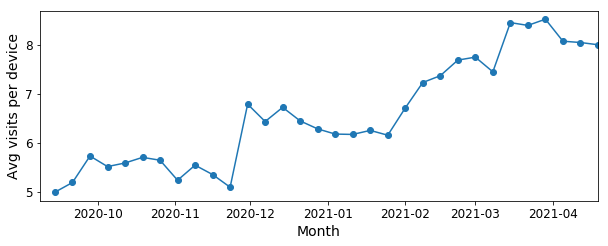

In [12]:
total_visits = np.array([m.sum() for m in visits])[within_range]
total_devices = np.sum(cbg_device_counts, axis=0)
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot_date(kept_datetimes, total_visits / total_devices, linestyle='-')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_intersect, max_intersect)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Avg visits per device', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figs/fig1c.pdf', bbox_inches='tight')

# Figure 2. Z assignment variable

In [13]:
# load processed county-level dynamic variables
path_to_data = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/county_dynamic_attrs_2021_t1t2.pkl')
with open(path_to_data, 'rb') as f:
    fips, population, tier_dates, blueprint_stages, tiers, assignment_vars = pickle.load(f)
print(tiers.shape, assignment_vars.shape)

(9, 58) (9, 58)


## Figure 2a. Z vs tier

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  37.  38.  39.  40.]
purple (289,)
0
red (181,)
9


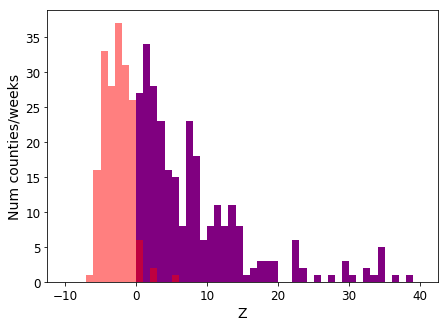

In [14]:
bins = np.linspace(-10, 40, 51)
fig, ax = plt.subplots(figsize=(7,5))
print(bins)

z_vec_t1 = assignment_vars[tiers == 1]
print('purple', z_vec_t1.shape)
print(np.sum(z_vec_t1 < 0))  # non-compliers
ax.hist(z_vec_t1, bins=bins, color='purple')

z_vec_t2 = assignment_vars[tiers == 2]
print('red', z_vec_t2.shape)
print(np.sum(z_vec_t2 >= 0))  # non-compliers
ax.hist(z_vec_t2, bins=bins, color='red', alpha=0.5)

ax.set_xlabel('Z', fontsize=14)
ax.set_ylabel('Num counties/weeks', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figs/fig2a.pdf', bbox_inches='tight')

# Figure 3. RD plots

In [15]:
# load saved tensors (n_weeks, n_counties, n_counties) per POI group
# representing total num visits (within group) from county to county in each week
path_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'poi_group2county_county_tensor.pkl')
with open(path_fn, 'rb') as f:
    group2tensor = pickle.load(f)

# load total device count per county and week
path_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_device_counts.pkl')
with open(path_fn, 'rb') as f:
    county_device_counts = pickle.load(f)

# num POIs per group
path_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'group2poi_counts.pkl')
with open(path_fn, 'rb') as f:
    group2poi_counts = pickle.load(f)

In [2]:
ca_dir = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA')
county_data_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/county_dynamic_attrs_2021_t1t2.pkl')
dset = CBGPOIDataset(directory=ca_dir, start_date='2021-02-01', end_date='2021-03-29', 
                     path_to_county_data=county_data_fn, cbg_count_min=50, poi_count_min=30,
                     load_distances_dynamically=True)

Loading /dfs/project/safegraph-homes/all_aggregate_data/raw_safegraph_data/open_census_data/safegraph_open_census_data/metadata/cbg_field_descriptions.csv


/dfs/scratch0/serinac/covid_spillovers_public/helper_methods_for_aggregate_data_analysis.py:1348: RuntimeWarning: invalid value encountered in true_divide
  new_df[group] = np.sum(df[cols].values, axis=1) / totals


Loaded data from /dfs/project/safegraph-homes/all_aggregate_data/cbg_poi_data/CA
Keeping data for 9 weeks, from 2021-02-01 to 2021-03-29
Keeping 22972/23212 CBGs with at least 50 nonzero visits
Keeping 128655/614847 POIs with at least 30 nonzero visits
Keeping 9/9 ACS fields that are estimate, not margin of error, and cover at least 90% of CBGs.
Filling remaining NaN entries (0.356% of all entries) with medians.
480 POIs (0.37%) are missing sub_category
106 POIs (0.08%) are missing top_category
Found 1 values <= 0 in CBG device counts -> clipping to 2
Applying min-max scaling to CBG and POI attributes (besides POI categories).
Loaded dynamic county data from /dfs/project/safegraph-homes/all_aggregate_data/cbg_poi_data/CA/county_dynamic_attrs_2021_t1t2.pkl
Modeling 176 subcategories and 25 POI groups


In [3]:
adj_dict = helper.load_county_adjacency_dict()  # load adjacency matrix for counties

In [18]:
def get_within_county_data_points(group=None, min_visits=20):
    if group is None:
        tensor = 0
        for g in group2tensor:
            tensor += group2tensor[g]
    else:
        tensor = group2tensor[group]
    all_z = []
    all_y = []
    for i, cbg_county in enumerate(dset.indices['counties']):
        within_county_visits = tensor[:, i, i]
        if np.mean(within_county_visits) >= min_visits:
            valid_weeks = np.isin(dset.county_tiers[:, i], [1, 2])  # purple or red tier
            valid_weeks[5] = False  # skip week 5
            device_counts = county_device_counts[:, i]
            if group is None:
                num_pois_in_group = np.sum([group2poi_counts[g][i] for g in dset.poi_group_labels])
            else:
                num_pois_in_group = group2poi_counts[group][i]
            normalized_visits = tensor[:, i, i] / (device_counts * num_pois_in_group)
            all_z.append(dset.county_assignment_vars[valid_weeks, i])
            all_y.append(normalized_visits[valid_weeks])
    all_z = np.concatenate(all_z)
    all_y = 1000 * np.concatenate(all_y)
    print('below 0: %d data points; above 0: %d data points' % (np.sum(all_z < 0), np.sum(all_z >= 0)))
    return all_z, all_y

In [19]:
def get_cross_county_data_points_changing_poi(group=None, min_visits=20, cbg_condition='control', max_z=10):
    if group is None:
        tensor = 0
        for g in group2tensor:
            tensor += group2tensor[g]
    else:
        tensor = group2tensor[group]
    all_z = []
    all_y = []
    for i, cbg_county in enumerate(dset.indices['counties']):
        device_counts = county_device_counts[:, i]
        if cbg_condition == 'control':
            valid_weeks_cbg = (dset.county_tiers[:, i] == 1) & (dset.county_assignment_vars[:, i] <= max_z)  # when cbg county was in purple
        else:
            valid_weeks_cbg = (dset.county_tiers[:, i] == 2) & (dset.county_assignment_vars[:, i] >= -max_z)  # when cbg county was in red
        valid_weeks_cbg[5] = False  # skip week 5
        for j, poi_county in enumerate(dset.indices['counties']):
            cross_county_visits = tensor[:, i, j]
            if i != j and np.mean(cross_county_visits) >= min_visits:
                valid_weeks_poi = np.isin(dset.county_tiers[:, j], [1, 2])  # purple or red tier
                valid_weeks = valid_weeks_cbg & valid_weeks_poi
                if group is None:
                    num_pois_in_group = np.sum([group2poi_counts[g][j] for g in group2poi_counts])
                else:
                    num_pois_in_group = group2poi_counts[group][j]
                normalized_visits = cross_county_visits / (device_counts * num_pois_in_group)
                all_z.append(dset.county_assignment_vars[valid_weeks, j])
                all_y.append(normalized_visits[valid_weeks])
    all_z = np.concatenate(all_z)
    all_y = 1000 * np.concatenate(all_y)
    print('below 0: %d data points; above 0: %d data points' % (np.sum(all_z < 0), np.sum(all_z >= 0)))
    return all_z, all_y

In [20]:
def make_rd_plot(all_z, all_y, ax, plot_polyfit=True, z_order=1, xlim=(-7, 20), interval=0.5):    
    z_bins = np.arange(xlim[0], xlim[1]+interval, interval)
    bins_kept = []
    avg_y = []
    size = []
    for bin_start in z_bins:  # plot average outcome per bin
        y_in_bin = all_y[(all_z >= bin_start) & (all_z < (bin_start+interval))]
        if len(y_in_bin) >= 3:
            avg_y.append(np.mean(y_in_bin))
            bins_kept.append(bin_start)
            size.append(len(y_in_bin))
    scaling = 200 / np.mean(size) 
    ax.scatter(np.array(bins_kept)+(interval/2), avg_y, s=np.array(size)*scaling, alpha=0.5)
        
    if plot_polyfit:
        # plot fit to the left of the cutoff
        z0 = all_z[all_z < 0]
        y0 = all_y[all_z < 0]
        p = np.poly1d(np.polyfit(z0, y0, z_order))
        reg_x = np.linspace(np.min(all_z), 0, 100)
        ax.plot(reg_x, p(reg_x), color='black')
        # plot fit to the right of the cutoff
        z1 = all_z[(all_z >= 0) & (all_z <= xlim[1])]
        y1 = all_y[(all_z >= 0) & (all_z <= xlim[1])]
        p = np.poly1d(np.polyfit(z1, y1, z_order))
        reg_x = np.linspace(0, xlim[1], 100)
        ax.plot(reg_x, p(reg_x), color='black')
        
    ax.set_xlabel('Z', fontsize=14)
    ax.set_ylabel('Avg visits per device & POI (per 1000)', fontsize=14)
    ax.set_xlim(xlim)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ymin, ymax = plt.ylim()
    ax.vlines([0], ymin, ymax)

## Figure 3a. Within-county visits

below 0: 142 data points; above 0: 274 data points


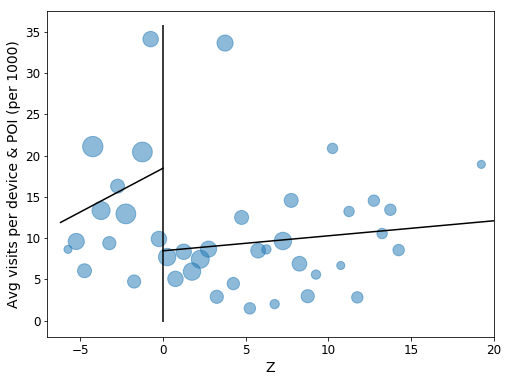

In [21]:
all_z, all_y = get_within_county_data_points(None)
fig, ax = plt.subplots(figsize=(8, 6))
make_rd_plot(all_z, all_y, ax, z_order=1, xlim=(-7, 20), interval=0.5)
plt.savefig('./figs/fig3a.pdf', bbox_inches='tight')

## Figure 3b. Cross-county visits

below 0: 916 data points; above 0: 3269 data points


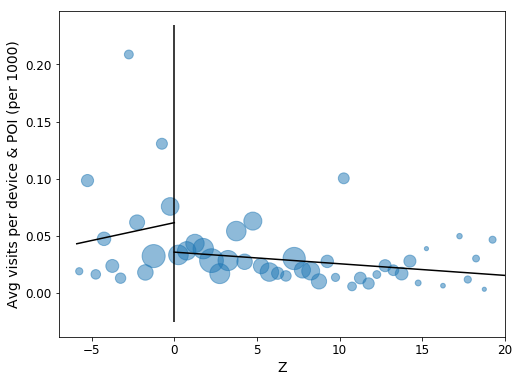

In [22]:
all_z, all_y = get_cross_county_data_points_changing_poi(None, min_visits=10, cbg_condition='control', max_z=5)
fig, ax = plt.subplots(figsize=(8, 6))
make_rd_plot(all_z, all_y, ax, z_order=1, xlim=(-7, 20), interval=0.5)
plt.savefig('./figs/fig3b.pdf', bbox_inches='tight')

# Figure 4. Spillovers

In [7]:
# experiments with nnz sampled and different negative samples
fns = ['test_poireg_t1t2_h5_adj_v0_2022_04_24_15_48_47',
       'test_poireg_t1t2_h5_adj_v1_2022_04_24_15_49_40',
       'test_poireg_t1t2_h5_adj_v2_2022_04_24_15_50_14',
       'test_poireg_t1t2_h5_adj_v3_2022_04_24_15_50_44',
       'test_poireg_t1t2_h5_adj_v4_2022_04_24_15_51_20',
       'test_poireg_t1t2_h5_adj_v5_2022_04_24_15_53_01',
       'test_poireg_t1t2_h5_adj_v6_2022_04_24_15_53_32',
       'test_poireg_t1t2_h5_adj_v7_2022_04_24_15_54_00',
       'test_poireg_t1t2_h5_adj_v8_2022_04_24_15_55_14',
       'test_poireg_t1t2_h5_adj_v9_2022_04_24_15_55_47']

## Fitted parameters 

{'Other': 0, 'Automobile Dealers': 1, 'Automotive Parts, Accessories, and Tire Stores': 2, 'Building Material and Supplies Dealers': 3, 'Clothing Stores': 4, 'Department Stores': 5, 'Drinking Places (Alcoholic Beverages)': 6, 'Elementary and Secondary Schools': 7, 'Gasoline Stations': 8, 'General Merchandise Stores, including Warehouse Clubs and Supercenters': 9, 'Grocery Stores': 10, 'Health and Personal Care Stores': 11, 'Lessors of Real Estate': 12, 'Museums, Historical Sites, and Similar Institutions': 13, 'Office Supplies, Stationery, and Gift Stores': 14, 'Other Amusement and Recreation Industries': 15, 'Other Miscellaneous Store Retailers': 16, 'Religious Organizations': 17, 'Sporting Goods, Hobby, and Musical Instrument Stores': 18, 'Traveler Accommodation': 19, 'Used Merchandise Stores': 20, 'Full-Service Restaurants': 21, 'Snack and Nonalcoholic Beverage Bars': 22, 'Limited-Service Restaurants': 23, 'Fitness and Recreational Sports Centers': 24}


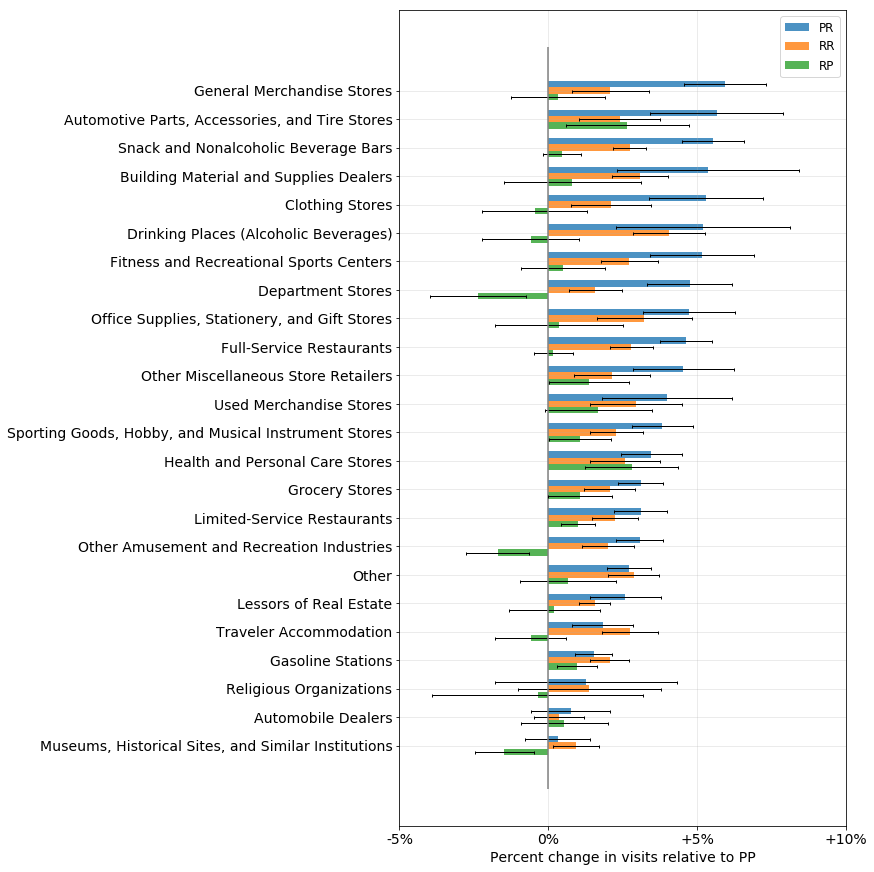

In [24]:
device = t.device('cpu')
group2idx = {g:i for i,g in enumerate(dset.poi_group_labels)}
print(group2idx)
del group2idx['Elementary and Secondary Schools']  # poor coverage
h5_df = summarize_tier_pair_weights_over_multiple_models(fns, device, group2idx)
plot_tier_pair_weights(h5_df, [(0, 1), (1, 1), (1, 0)], sort_col='0->1 mean', xlim=(0.95, 1.1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/fig4.pdf', bbox_inches='tight')

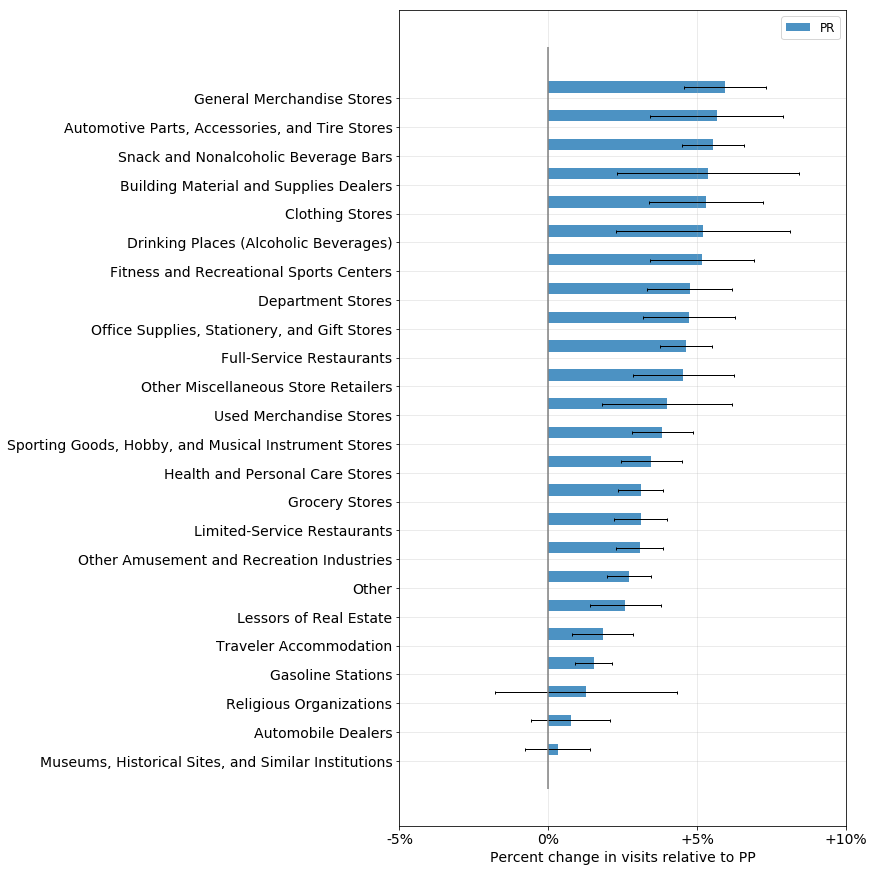

In [8]:
plot_tier_pair_weights(h5_df, [(0, 1)], sort_col='0->1 mean', xlim=(0.95, 1.1), labels=['PR'])
plt.savefig('./figs/fig4_PR.pdf', bbox_inches='tight')

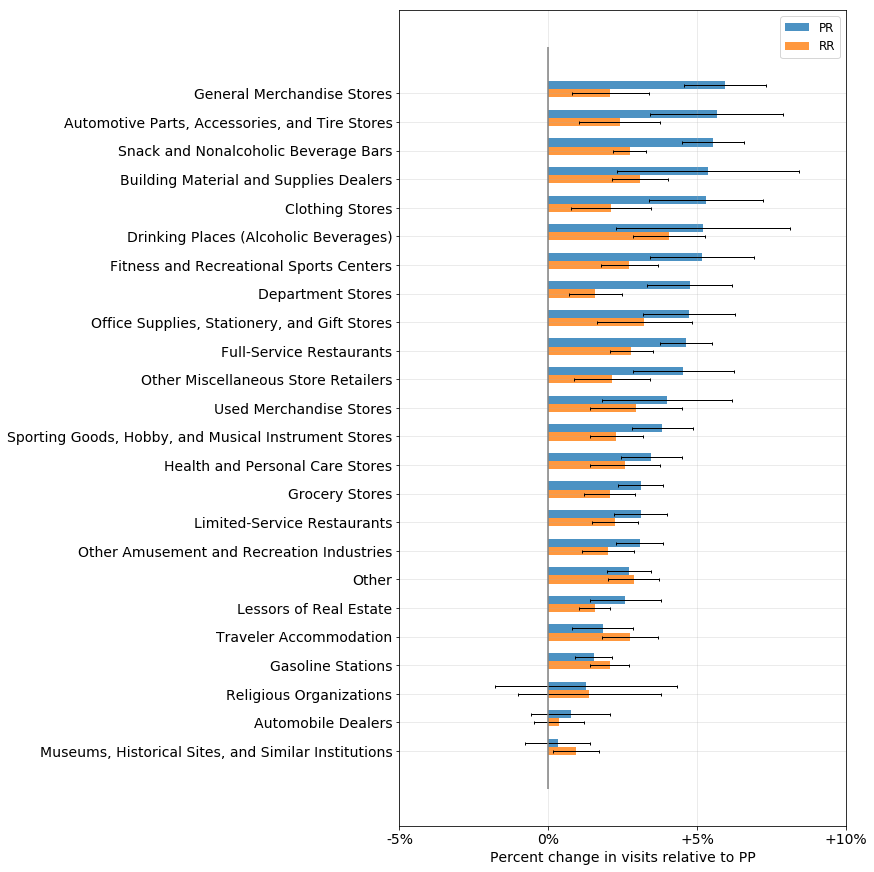

In [9]:
plot_tier_pair_weights(h5_df, [(0, 1), (1, 1)], sort_col='0->1 mean', xlim=(0.95, 1.1), labels=['PR', 'RR'])
plt.savefig('./figs/fig4_PR_RR.pdf', bbox_inches='tight')

## Local vs global analysis 

In [4]:
# load within-county model and weights
save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'same_county_weights_2022_04_18_16_45_59.pkl')
with open(save_path, 'rb') as f:
    counties, group_labels, within_county_weights = pickle.load(f)
    experiment = 'test_poireg_t1t2_h5_same_2022_04_18_16_45_59'
model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
device = t.device('cpu')
state_dict_same = t.load(model_fn, map_location=device)
tier_self_weights = np.exp(state_dict_same['tier_self_weights'].detach().numpy())

In [6]:
# load cross-county model and weights
all_prs = []
for i, experiment in enumerate(fns):
    save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_county_weights_v%s.pkl' % i)
    with open(save_path, 'rb') as f:
        counties, group_labels, county_county_weights = pickle.load(f)
    model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
    state_dict_adj = t.load(model_fn, map_location=device)
    tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
    prs = compute_percent_reduction(dset, tier_self_weights, within_county_weights, 
                                tier_pair_weights, county_county_weights)
    print(i, np.mean(prs))
    all_prs.append(prs)
all_prs = np.array(all_prs)

# get mean of means and CI
large_prs = all_prs
means = np.mean(large_prs, axis=1)
mean_of_means = np.mean(means)
se = np.std(means, axis=0, ddof=1)
print('%.3f (%.3f-%.3f)' % (mean_of_means, mean_of_means - (1.96 * se), mean_of_means + (1.96 * se)))

0 0.5245698975318397
1 0.5052302090592566
2 0.5133039005564857
3 0.5444518937994874
4 0.494546690576883
5 0.5429211086229778
6 0.5579314396835878
7 0.5406413107794686
8 0.5402317279470824
9 0.5114617261412245
0.528 (0.487-0.568)


In [7]:
# from https://www.gov.ca.gov/2020/12/03/california-health-officials-announce-a-regional-stay-at-home-order-triggered-by-icu-capacity/
reg1 = "Northern California: Del Norte, Glenn, Humboldt, Lake, Lassen, Mendocino, Modoc, Shasta, Siskiyou, Tehama, Trinity"
reg2 = "Bay Area: Alameda, Contra Costa, Marin, Monterey, Napa, San Francisco, San Mateo, Santa Clara, Santa Cruz, Solano, Sonoma"
reg3 = "Greater Sacramento: Alpine, Amador, Butte, Colusa, El Dorado, Nevada, Placer, Plumas, Sacramento, Sierra, Sutter, Yolo, Yuba"
reg4 = "San Joaquin Valley: Calaveras, Fresno, Kern, Kings, Madera, Mariposa, Merced, San Benito, San Joaquin, Stanislaus, Tulare, Tuolumne"
reg5 = "Southern California: Imperial, Inyo, Los Angeles, Mono, Orange, Riverside, San Bernardino, San Diego, San Luis Obispo, Santa Barbara, Ventura"

In [8]:
# construct true county2macrocounty from Regional Stay-At-Home
name2fips = helper.load_county_name_to_fips()
county2macrocounty = {}
reg_names = []
for reg, reg_str in enumerate([reg1, reg2, reg3, reg4, reg5]):
    reg_name, counties = reg_str.split(': ', 1) 
    reg_names.append(reg_name)
    counties = counties.split(', ')
    print(reg_name, len(counties))
    for c in counties:
        full_name = '%s County, CA' % c
        if full_name in name2fips:
            county2macrocounty[name2fips[full_name]] = reg
        else:
            print('Could not find %s in name2fips' % full_name)

Northern California 11
Bay Area 11
Greater Sacramento 13
San Joaquin Valley 12
Southern California 11


In [11]:
# compare to macrocounty - ACTUAL
all_prs = []
for i, experiment in enumerate(fns):
    save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_county_weights_v%s.pkl' % i)
    with open(save_path, 'rb') as f:
        counties, group_labels, county_county_weights = pickle.load(f)
    model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
    state_dict_adj = t.load(model_fn, map_location=device)
    tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
    prs = compute_percent_reduction_macrocounty(dset, tier_self_weights, within_county_weights, 
                                tier_pair_weights, county_county_weights, county2macrocounty)
    print(i, np.mean(prs)) 
    all_prs.append(prs)
all_prs = np.array(all_prs)

large_prs = all_prs
means = np.mean(large_prs, axis=1)
mean_of_means = np.mean(means)
se = np.std(means, axis=0, ddof=1)
print('MEAN: %.3f (%.3f-%.3f)' % (mean_of_means, mean_of_means - (1.96 * se), mean_of_means + (1.96 * se)))

0 0.9191050394447065
1 0.9171422281682162
2 0.9179505106499423
3 0.9223323853159973
4 0.9138807389611461
5 0.9218464802809228
6 0.923742401892092
7 0.9214407338570586
8 0.9219032127345568
9 0.9174222334316778
MEAN: 0.920 (0.914-0.926)


In [12]:
# compare to macrocounty - RANDOM
macrocounty_assignments = np.concatenate([np.arange(5) for i in range(12)])[:58]
np.random.seed(0)
np.random.shuffle(macrocounty_assignments)
counties = sorted(list(dset.county2idx.keys()))
county2macrocounty = {c:m for c,m in zip(counties, macrocounty_assignments)}
all_prs = []
for i, experiment in enumerate(fns):
    save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_county_weights_v%s.pkl' % i)
    with open(save_path, 'rb') as f:
        counties, group_labels, county_county_weights = pickle.load(f)
    model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
    state_dict_adj = t.load(model_fn, map_location=device)
    tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
    prs = compute_percent_reduction_macrocounty(dset, tier_self_weights, within_county_weights, 
                                tier_pair_weights, county_county_weights, county2macrocounty)
    print(i, np.mean(prs))
    all_prs.append(prs)
all_prs = np.array(all_prs)

large_prs = all_prs
means = np.mean(large_prs, axis=1)
mean_of_means = np.mean(means)
se = np.std(means, axis=0, ddof=1)
print('MEAN: %.3f (%.3f-%.3f)' % (mean_of_means, mean_of_means - (1.96 * se), mean_of_means + (1.96 * se)))

0 0.6253151641636795
1 0.6077122801769135
2 0.616281825898054
3 0.6419433513841375
4 0.6023532662046468
5 0.6407168506759339
6 0.6525707069175841
7 0.6384127092715579
8 0.6381495287542004
9 0.6154286144394959
MEAN: 0.628 (0.595-0.661)


In [13]:
# random assignments
print(Counter(county2macrocounty.values()))
county2macrocounty

Counter({0: 12, 2: 12, 1: 12, 4: 11, 3: 11})


{6001: 0,
 6003: 4,
 6005: 2,
 6007: 2,
 6009: 1,
 6011: 2,
 6013: 3,
 6015: 0,
 6017: 2,
 6019: 3,
 6021: 4,
 6023: 0,
 6025: 4,
 6027: 0,
 6029: 2,
 6031: 1,
 6033: 2,
 6035: 2,
 6037: 4,
 6039: 1,
 6041: 3,
 6043: 1,
 6045: 2,
 6047: 3,
 6049: 4,
 6051: 1,
 6053: 0,
 6055: 0,
 6057: 0,
 6059: 1,
 6061: 4,
 6063: 0,
 6065: 0,
 6067: 3,
 6069: 3,
 6071: 0,
 6073: 2,
 6075: 3,
 6077: 1,
 6079: 1,
 6081: 3,
 6083: 1,
 6085: 2,
 6087: 2,
 6089: 4,
 6091: 1,
 6093: 3,
 6095: 1,
 6097: 1,
 6099: 4,
 6101: 4,
 6103: 4,
 6105: 0,
 6107: 3,
 6109: 0,
 6111: 3,
 6113: 2,
 6115: 4}

In [48]:
avg_tier_pair_weights = 0
for i, experiment in enumerate(fns):
    save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_county_weights_v%s.pkl' % i)
    with open(save_path, 'rb') as f:
        counties, group_labels, county_county_weights = pickle.load(f)
    model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
    state_dict_adj = t.load(model_fn, map_location=device)
    tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
    avg_tier_pair_weights += tier_pair_weights
avg_tier_pair_weights /= len(fns)

G = make_networkx_graph_for_metis(dset, tier_self_weights, within_county_weights, avg_tier_pair_weights, 
                                               county_county_weights)

In [55]:
ks = [2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
mean_for_k = []
lower_for_k = []
upper_for_k = []
for k in ks:
    cut, parts = metis.part_graph(G, k, ubvec=[1.05], contig=True, recursive=True)
    num_parts = len(set(parts))
    if num_parts != k:
        raise Exception('WARNING: only %d parts' % num_parts)
    print(k, Counter(parts))
    county2macrocounty = {}
    for ci, p in zip(G.nodes, parts):
        county2macrocounty[dset.indices['counties'][ci]] = p
    
    all_prs = []
    for i, experiment in enumerate(fns):
        save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_county_weights_v%s.pkl' % i)
        with open(save_path, 'rb') as f:
            counties, group_labels, county_county_weights = pickle.load(f)
        model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
        state_dict_adj = t.load(model_fn, map_location=device)
        tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
        prs = compute_percent_reduction_macrocounty(dset, tier_self_weights, within_county_weights, 
                                    tier_pair_weights, county_county_weights, county2macrocounty)
        print(i, np.mean(prs)) 
        all_prs.append(prs)
    all_prs = np.array(all_prs)

    means = np.mean(all_prs, axis=1)
    mean_of_means = np.mean(means)
    se = np.std(means, axis=0, ddof=1)
    mean_for_k.append(mean_of_means)
    lower_for_k.append(mean_of_means - (1.96 * se))
    upper_for_k.append(mean_of_means + (1.96 * se))
    print('MEAN: %.3f (%.3f-%.3f)' % (mean_of_means, lower_for_k[-1], upper_for_k[-1]))
    print()
    
# 0.528 (0.487-0.568) -- from county-level
ks.append(58)
mean_for_k.append(0.528)
lower_for_k.append(0.487)
upper_for_k.append(0.568)

2 Counter({0: 30, 1: 28})
0 0.9707588868724839
1 0.9690530890692223
2 0.9703030914256575
3 0.9721430828100753
4 0.9691274367297653
5 0.9721174666861633
6 0.9730501638273386
7 0.9719854709746825
8 0.9718233818737961
9 0.970308636343072
MEAN: 0.971 (0.968-0.974)

3 Counter({2: 21, 0: 19, 1: 18})
0 0.953008774448598
1 0.9529292523502282
2 0.9520474024485384
3 0.9543648073565417
4 0.9493141870409434
5 0.9539682983239643
6 0.9552234251623816
7 0.9538844204532301
8 0.9542399890405044
9 0.9516400569616196
MEAN: 0.953 (0.950-0.956)

4 Counter({1: 15, 3: 15, 0: 15, 2: 13})
0 0.9455826078473912
1 0.942691073549897
2 0.9453011838536381
3 0.9482166535342762
4 0.9427971079383543
5 0.9479798324328101
6 0.9495025731657972
7 0.9479741054451578
8 0.947884823908187
9 0.944982123224683
MEAN: 0.946 (0.942-0.951)

5 Counter({4: 13, 0: 12, 3: 12, 2: 11, 1: 10})
0 0.9298050335258249
1 0.9261653630146526
2 0.9291156931882241
3 0.9332716449346046
4 0.9260863107021644
5 0.932960787236367
6 0.9350349905475411
7 

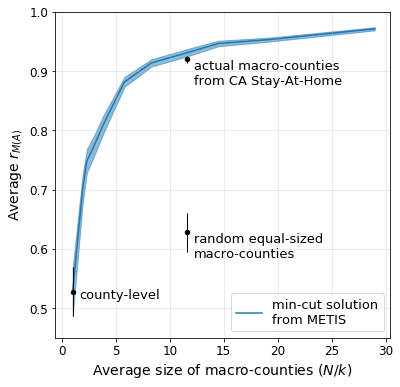

In [86]:
region_sizes = 58 / np.array(ks)
plt.figure(figsize=(6,6))
plt.plot(region_sizes, mean_for_k, color='tab:blue', label='min-cut solution\nfrom METIS', zorder=1)
plt.xlabel(r'Average size of macro-counties ($N/k$)', fontsize=14)
plt.ylabel(r'Average $r_{M(A)}$', fontsize=14)
plt.legend(fontsize=13, loc='lower right')
plt.fill_between(region_sizes, lower_for_k, upper_for_k, color='tab:blue', alpha=0.5, zorder=0)
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0.45, 1)

x, y = region_sizes[-1], mean_for_k[-1]
plt.scatter([x], [y],  color='black', s=20, zorder=2)
plt.errorbar([x], [y], yerr=y-lower_for_k[-1], color='black', elinewidth=1, zorder=2)
plt.annotate('county-level', (x, y),  fontsize=13, 
             xycoords='data', xytext=(7, -7), textcoords='offset points', zorder=2)

# 0.920 (0.914-0.926)
x, y = 58/5, 0.920
plt.scatter([x], [y], color='black', s=20, zorder=2)
plt.errorbar([x], [y], yerr=0.006, color='black', elinewidth=1, zorder=2)
plt.annotate('actual macro-counties\nfrom CA Stay-At-Home', (x, y),  fontsize=13,
            xycoords='data', xytext=(7, -25), textcoords='offset points', zorder=2)

# 0.628 (0.595-0.661)
x, y = 58/5, 0.628
plt.scatter([x], [y],  color='black', s=20, zorder=2)
plt.errorbar([x], [y], yerr=0.033, color='black', elinewidth=1, zorder=2)
plt.annotate('random equal-sized\nmacro-counties', (x, y),  fontsize=13,
            xycoords='data', xytext=(7, -25), textcoords='offset points', zorder=2)
plt.savefig('./figs/fig5a.pdf', bbox_inches='tight')

Counter({4: 10, 3: 9, 5: 9, 2: 8, 6: 8, 1: 7, 0: 7})
0 0.9131431558992067
1 0.9127105838227338
2 0.9117340832252719
3 0.9162663514110218
4 0.9068067619483894
5 0.915234396180387
6 0.917313190507619
7 0.914853959164162
8 0.9157130317447446
9 0.9106361164688793
MEAN: 0.913 (0.907-0.920)


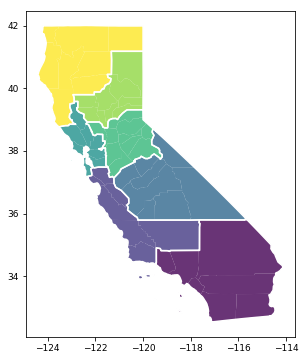

In [85]:
# plot k=7 as an example
cut, parts = metis.part_graph(G, 7, ubvec=[1.05], contig=True, recursive=True)
print(Counter(parts))
county2macrocounty = {}
for ci, p in zip(G.nodes, parts):
    county2macrocounty[dset.indices['counties'][ci]] = p

all_prs = []
for i, experiment in enumerate(fns):
    save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_county_weights_v%s.pkl' % i)
    with open(save_path, 'rb') as f:
        counties, group_labels, county_county_weights = pickle.load(f)
    model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
    state_dict_adj = t.load(model_fn, map_location=device)
    tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
    prs = compute_percent_reduction_macrocounty(dset, tier_self_weights, within_county_weights, 
                                tier_pair_weights, county_county_weights, county2macrocounty)
    print(i, np.mean(prs)) 
    all_prs.append(prs)
all_prs = np.array(all_prs)

means = np.mean(all_prs, axis=1)
mean_of_means = np.mean(means)
se = np.std(means, axis=0, ddof=1)
print('MEAN: %.3f (%.3f-%.3f)' % (mean_of_means, mean_of_means - (1.96 * se), mean_of_means + (1.96 * se)))
    
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
ca_geom = geoData[geoData['STATE'] == '06'].sort_values(by='id')
macrocounties = [county2macrocounty[f] for f in sorted(county2macrocounty.keys())]
ca_geom['macrocounty'] = macrocounties
ca_geom['coords'] = ca_geom['geometry'].apply(lambda x: x.representative_point().coords[:])
ca_geom['coords'] = [coords[0] for coords in ca_geom['coords']]

fig, ax = plt.subplots(figsize=(6, 6))
ca_geom.plot('macrocounty', ax=ax, alpha=0.8)
for macrocounty, subdf in ca_geom.groupby('macrocounty'):
    polygon = subdf.geometry.unary_union
    gpd.GeoDataFrame(geometry=[polygon], crs=subdf.crs).boundary.plot(color='white', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('./figs/fig5b.pdf', bbox_inches='tight')

# Appendix figures

## Bandwidth selection

In [28]:
# analyze which data is kept when h=5
data_name = 't1t2_h5_r02_adj'
directory = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'sampled_data', data_name)
with open(os.path.join(directory, 'kwargs.pkl'), 'rb') as f:
    dset_kwargs, sampling_kwargs = pickle.load(f)
sampling_kwargs

{'control_tier': 1,
 'treatment_tier': 2,
 'min_Z': -5.0,
 'max_Z': 5.0,
 'cbg_treatment': None,
 'poi_treatment': None,
 'train_ratio': 1,
 'dist_scalar': 1,
 'visit_type': 'both',
 'only_keep_adjacent': 1,
 'neg_sample_rate': 0.02}

In [30]:
all_nnz = []
for week in np.arange(dset.num_weeks()):
    with open(os.path.join(directory, 'w%d_train_nnz.pkl' % week), 'rb') as f:
        train_nnz = pickle.load(f)
        print(week, len(train_nnz))
        all_nnz.append(train_nnz)
all_nnz = np.concatenate(all_nnz)
print(len(all_nnz))

0 5070
1 17753
2 53108
3 59133
4 188029
5 0
6 195358
7 110437
8 55716
684604


In [31]:
w_vec, c_vec, p_vec = dset.index_to_wcp(all_nnz)
cbg_counties = dset.cbg_county_indices[c_vec]
cbg_tiers = dset.county_tiers[w_vec, cbg_counties]
poi_counties = dset.poi_county_indices[p_vec]
poi_tiers = dset.county_tiers[w_vec, poi_counties]
assert all(cbg_counties != poi_counties)  # all adjacent
all_tier_pairs = zip(cbg_tiers, poi_tiers)
print(Counter(all_tier_pairs))

Counter({(2.0, 2.0): 309554, (1.0, 1.0): 289199, (1.0, 2.0): 48608, (2.0, 1.0): 37243})


In [32]:
for cbg_tier, poi_tier in [(1, 1), (1, 2), (2, 1), (2, 2)]:
    in_tier_pair = (cbg_tiers == cbg_tier) & (poi_tiers == poi_tier)
    county_pairs = zip(cbg_counties[in_tier_pair], poi_counties[in_tier_pair])
    most_common = Counter(county_pairs).most_common()
    print(cbg_tier, poi_tier, np.sum(in_tier_pair), len(most_common))
    counts = np.array([t[1] for t in most_common])
    for p, ct in most_common[:5]:
        print(dset.indices['counties'][p[0]],dset.indices['counties'][p[1]],
              ct, 100. * ct / np.sum(in_tier_pair))
    print()

1 1 289199 126
6067 6061 21969 7.596499296332284
6037 6059 16643 5.7548608397677725
6013 6001 14783 5.111705088883433
6059 6037 11477 3.9685476090857854
6061 6067 10762 3.721313005923257

1 2 48608 71
6077 6067 4323 8.893597761685319
6067 6113 4046 8.323732718894009
6075 6081 3133 6.4454410796576695
6029 6037 2891 5.94758064516129
6115 6101 2863 5.889976958525345

2 1 37243 74
6067 6077 3892 10.450285959777677
6113 6067 3097 8.315656633461321
6017 6067 3004 8.065945278307334
6107 6019 2782 7.469860107939747
6081 6075 1977 5.308380098273501

2 2 309554 177
6067 6061 23656 7.641962307061126
6065 6071 23291 7.524050731051771
6037 6059 18607 6.010906013167331
6071 6065 17228 5.565426387641574
6065 6059 15198 4.909644197781324



/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


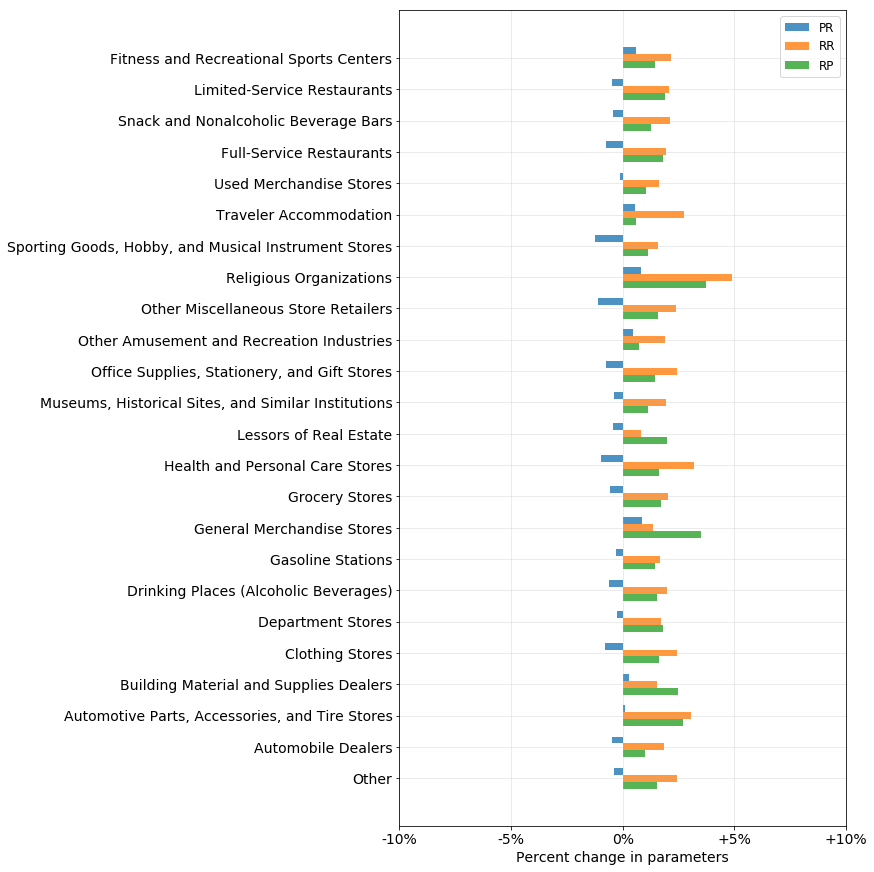

In [33]:
# Appendix: comparison of h=4 and h=5
h4_df = summarize_tier_pair_weights_over_multiple_models(['test_poireg_t1t2_h4_adj_2022_04_19_11_50_32'], device, group2idx)
plot_percent_change_in_weights(h4_df, h5_df, [(0, 1), (1, 1), (1, 0)], xlim=(-0.1, 0.1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/h4_v_h5.pdf', bbox_inches='tight')


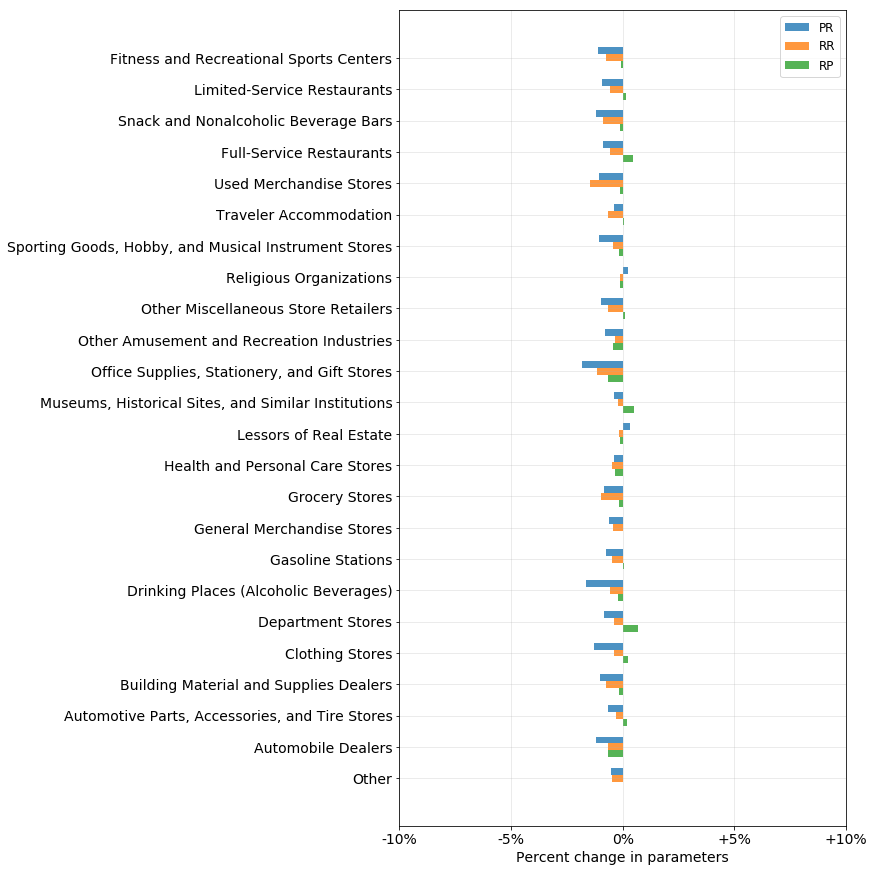

In [34]:
# Appendix: comparison of h=6 and h=5
h6_df = summarize_tier_pair_weights_over_multiple_models(['test_poireg_t1t2_h6_adj_2022_04_19_11_54_53'], device, group2idx)
plot_percent_change_in_weights(h6_df, h5_df, [(0, 1), (1, 1), (1, 0)], xlim=(-0.1, 0.1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/h6_v_h5.pdf', bbox_inches='tight')


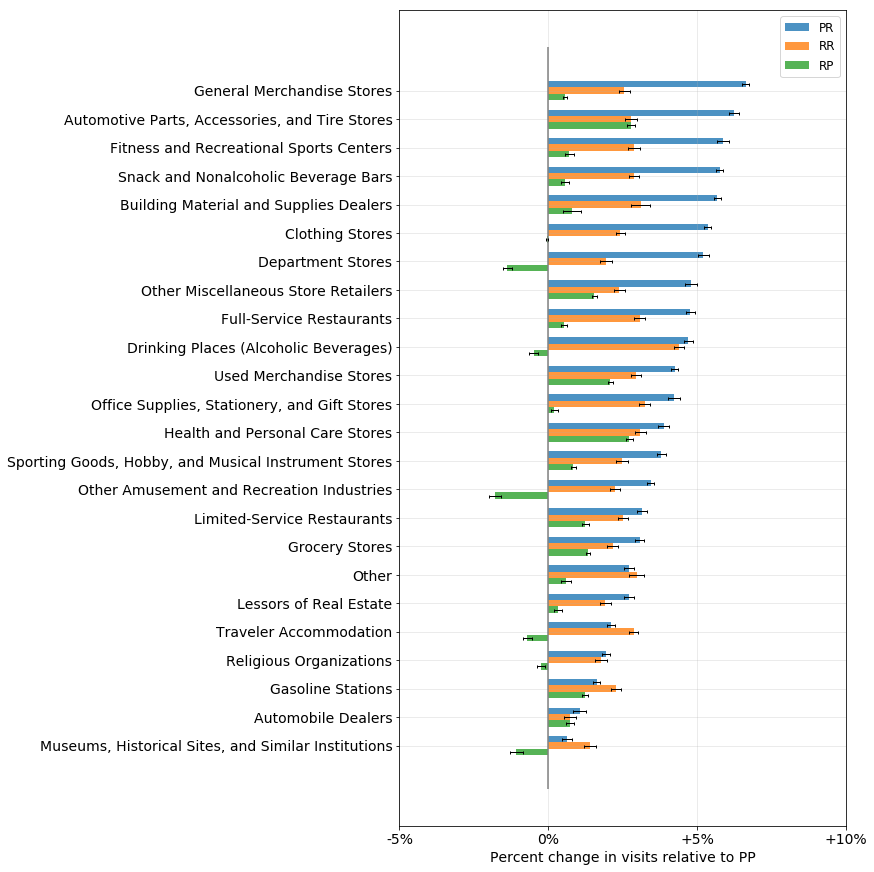

In [35]:
# Appendix: CIs from only negative sampling and no non-zero sampling
fns = ['neg_sampling_02_v%d_2022_04_27_13_18_13' % v for v in range(10)]
neg02_df = summarize_tier_pair_weights_over_multiple_models(fns, device, group2idx)
plot_tier_pair_weights(neg02_df, [(0, 1), (1, 1), (1, 0)], sort_col='0->1 mean', xlim=(0.95, 1.1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/neg_sample_cis.pdf', bbox_inches='tight')
